In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

$K^{\pm}$ \
Mass $m = 493.677 \pm 0.016$ MeV (S = 2.8) \
Mean life $\tau = (1.2380 \pm 0.0020) * 10^{-8}$ s (S = 1.8) \
$c\tau = 3.711$ m 

 

$\pi^{\pm}$ \
Mass $m = 139.57039 \pm 0.00018$ MeV (S = 1.8) \
Mean life $\tau = (2.6033 \pm 0.0005) * 10^{-8}$ s (S = 1.2) \
$c\tau = 7.8045$ m \
average decay length of $\pi^+ = 4188$ m

[ 3.07689461e+03 -4.35275504e-04  3.31141657e+01]


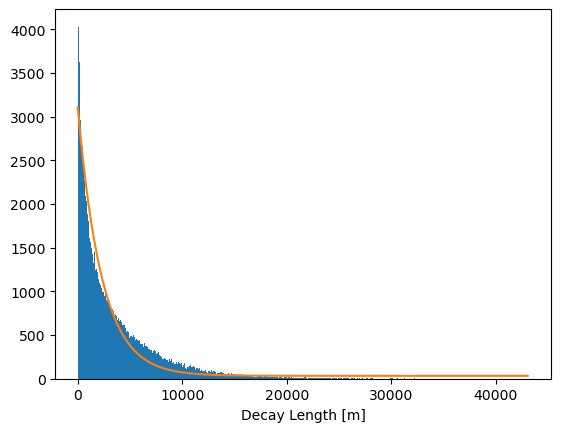

In [2]:
data = np.loadtxt('dec_lengths.txt')
counts, bins, _ = plt.hist(data,bins=500,density=False)
xdata = bins[:-1]
ydata = counts

def model_func(x, a, b, c):
    return a * np.exp(b * x) + c

opt_parms, parm_cov = curve_fit(model_func, xdata, ydata, [4000, -0.0004, 0])
print(opt_parms)

plt.plot(xdata,model_func(xdata, *opt_parms))
plt.xlabel('Decay Length [m]')
plt.show()

$P(x) = ???$

$K(x) = ???$

$T(x) = 0.84 \cdot P(x) + 0.16 \cdot K(x)$

In [7]:

data_mean = np.mean(data)
Kaon_mean = (data_mean - 0.84 * 4188)/0.16

print('data mean:', data_mean)
print('Kaon mean:', Kaon_mean)

data mean: 3603.7703219794967
Kaon mean: 536.5645123718537
